In [1]:
from IPython import get_ipython
if "google.colab" in str(get_ipython()):
    using_colab = True
else:
    using_colab = False
print("Using Colab:", using_colab)


Using Colab: False


In [2]:
if using_colab:
    %pip install -q bagpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import rosbag
from typing import Tuple, List, Dict
from IPython.display import display

import os
from tqdm import tqdm

import torch
import time
import cv2
import gc

# Dataset Handling


## Visualization and utils functions


In [23]:
# Visualization functions
def plot_img(img: np.ndarray, grid=False, real_ticks=False, show=True, cmap="gray"):
    if real_ticks:
        plt.xticks(np.arange(img.shape[1] + 1) - 0.5, np.arange(img.shape[1] + 1))
        plt.yticks(np.arange(img.shape[0] + 1) - 0.5, np.arange(img.shape[0] + 1))
    plt.grid(grid)
    plt.imshow(img, cmap=cmap)
    if show:
        plt.show()


# Utils functions
def image_from_buffer(
    data: bytes, width: int, height: int, channels: int
) -> np.ndarray:
    return (
        np.frombuffer(data, dtype=np.uint8).reshape(height, width, channels).squeeze()
    )


def bgr_to_rgb(img: np.ndarray) -> np.ndarray:
    return img[..., ::-1]


def save_video(path, frames, width, height, fps):
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(path, fourcc, fps, (width, height))

    for frame in frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        out.write(frame)

    cap.release()
    out.release()


def save_video_tensors(path, frames, width, height, fps):
    frames = [(frame * 255).numpy().astype(np.uint8) for frame in frames]
    save_video(path, frames, width, height, fps)


## Dataset Inspection


### Inspect messages content


In [6]:
dataset_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_jenga_destroy.bag"
bag = rosbag.Bag(dataset_path)

for topic, msg, t in bag.read_messages(topics=["/dvs/image_raw"]):
    image_raw_msg = msg
    break

for topic, msg, t in bag.read_messages(topics=["/dvs/image_color"]):
    image_color_msg = msg
    break

for topic, msg, t in bag.read_messages(topics=["/dvs/events"]):
    events_msg = msg
    break

bag.close()

print("Raw Image Event")
print(str(image_raw_msg)[:200] + "...")
print()

print("Color Image Event")
print(str(image_color_msg)[:200] + "...")
print()

print("Events Event")
print(str(events_msg)[:300] + "...")
print()


Raw Image Event
header: 
  seq: 4672
  stamp: 
    secs: 1553514337
    nsecs:   3034266
  frame_id: ''
height: 260
width: 346
encoding: "mono8"
is_bigendian: 0
step: 346
data: [18, 19, 24, 19, 27, 23, 28, 20, 27, 22...

Color Image Event
header: 
  seq: 0
  stamp: 
    secs: 1553514337
    nsecs:   3034266
  frame_id: ''
height: 260
width: 346
encoding: "bgr8"
is_bigendian: 0
step: 1038
data: [0, 84, 84, 0, 84, 84, 0, 84, 88, 0, 79, 8...

Events Event
header: 
  seq: 3504
  stamp: 
    secs: 1553514337
    nsecs:  11357266
  frame_id: ''
height: 260
width: 346
events: 
  - 
    x: 123
    y: 250
    ts: 
      secs: 1553514336
      nsecs: 991362266
    polarity: True
  - 
    x: 195
    y: 70
    ts: 
      secs: 1553514336
      nsecs: 99136326...



##### **Image events content:**

**data**: binary image data encoded according to encoding

**encoding**: format used to encode the image data - e.g. mono8, bgr8

**width**, **height**: size of the image

**is_bigendian**: endianness of image

**step**: full row length in bytes

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Event events content:**

**events**: array of events

**width**, **height**: size of the camera sensor

**header**:

-   **seq**: consecutively increasing ID
-   **stamp**:
    -   **secs**: seconds since epoch
    -   **nsecs**: nanoseconds since stamp.secs
-   **frame_id**: frame this data is associated with - in this dataset is always empty

##### **Events format:**

**x**, **y**: coordinates of the pixel sensor

**polarity**: polarity of the event in {True, False}

**ts**:

-   **secs**: seconds since epoch
-   **nsecs**: nanoseconds since ts.secs


### Inspect message timestamps


In [5]:
i = 0
print("{:5}{:20}{}".format("", "Topic Name", "Event Timestamp"))
with rosbag.Bag(dataset_path) as b:
    for topic, msg, _ in b.read_messages(topics=["/dvs/events", "/dvs/image_color"]):
        print("{:3}) {:20}{}".format(i, topic, msg.header.stamp.to_sec()))

        if topic == "/dvs/events":
            print(
                "{:25}First event timestamp {} Last event timestamp {}".format(
                    "", msg.events[0].ts.to_sec(), msg.events[-1].ts.to_sec()
                )
            )

        i += 1
        if i == 15:
            break


     Topic Name          Event Timestamp
  0) /dvs/image_color    1553514337.0030344
  1) /dvs/events         1553514337.0113573
                         First event timestamp 1553514336.9913623 Last event timestamp 1553514337.0213542
  2) /dvs/image_color    1553514337.0280342
  3) /dvs/events         1553514337.0413592
                         First event timestamp 1553514337.0213573 Last event timestamp 1553514337.0513504
  4) /dvs/image_color    1553514337.0530353
  5) /dvs/events         1553514337.0713603
                         First event timestamp 1553514337.0513632 Last event timestamp 1553514337.0813544
  6) /dvs/image_color    1553514337.0780354
  7) /dvs/image_color    1553514337.1030352
  8) /dvs/events         1553514337.1113732
                         First event timestamp 1553514337.0813613 Last event timestamp 1553514337.1213531
  9) /dvs/image_color    1553514337.1280353
 10) /dvs/events         1553514337.1413844
                         First event timestamp 1553

The events are not completely sequential, since there can be two image events after each other (e.g. 6-7) but the first event timestamp of the next event is before the last image (e.g 8).

Moreover, there are some events that are acquired after the last image has been captured.


## Dataset Loading


In [7]:
# Download datasets if using Colab
if using_colab:
    import gdown

    datasets = {
        'simple_color_keyboard_2.zip': 'https://drive.google.com/uc?id=1hGdQ0WLGUjYA6snH-i1WY1zTm7HPDG9D&confirm=t',
        'simple_jenga_destroy.zip': 'https://drive.google.com/uc?id=1KqqJzcdhOF1h0TuKTXUfLjY1vhL28Dtl&confirm=t'
    }

    for name, url in datasets.items():
        gdown.download(url, name)
        !unzip name -d name.replace(".zip", "")

In [4]:
# Load dataset as Pandas dataframes
def load_bag_as_dataframes(
    dataset_path: str, image_type
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load the dataset from a rosbag file and return two pandas dataframe with events and images.
    `image_type` can be either `raw` or `color`.
    """
    if image_type not in ["raw", "color"]:
        raise Exception(
            "image_type argument can be either 'raw' or 'color', not " + image_type
        )

    image_topic = "/dvs/image_" + image_type

    bag = rosbag.Bag(dataset_path)

    events_list = []
    images_list = []

    w, h = 0, 0

    for topic, msg, t in tqdm(bag.read_messages(), total=bag.get_message_count()):
        if topic == image_topic:
            seq = msg.header.seq
            secs = msg.header.stamp.to_sec()
            width = msg.width
            height = msg.height
            w, h = width, height
            is_bigendian = msg.is_bigendian
            encoding = msg.encoding
            step = msg.step
            data = np.frombuffer(msg.data, dtype=np.uint8)
            image_event = [seq, secs, width, height, is_bigendian, encoding, step, data]
            images_list.append(image_event)

        elif topic == "/dvs/events":
            seq = msg.header.seq
            events = msg.events

            for event in events:
                polarity = event.polarity
                x = event.x
                y = event.y
                secs = event.ts.to_sec()

                event = [seq, x, y, secs, polarity]
                events_list.append(event)

    bag.close()

    events_df = pd.DataFrame(events_list, columns=["seq", "x", "y", "secs", "polarity"])
    images_df = pd.DataFrame(
        images_list,
        columns=[
            "seq",
            "secs",
            "width",
            "height",
            "is_bigendian",
            "encoding",
            "step",
            "data",
        ],
    )

    return events_df, images_df


In [8]:
events_df, images_df = load_bag_as_dataframes(dataset_path, image_type="color")
print("Events dataframe")
display(events_df)
print("Images dataframe")
display(images_df)


100%|██████████| 980/980 [00:16<00:00, 59.75it/s] 


Events dataframe


,seq,x,y,secs,polarity
0,3504,123,250,1.553514e+09,True
1,3504,195,70,1.553514e+09,True
2,3504,231,92,1.553514e+09,False
3,3504,171,197,1.553514e+09,False
4,3504,181,179,1.553514e+09,False
...,...,...,...,...,...
2843082,3773,194,193,1.553514e+09,False
2843083,3773,205,253,1.553514e+09,False
2843084,3773,133,255,1.553514e+09,False
2843085,3773,188,164,1.553514e+09,True


Images dataframe


,seq,secs,width,height,is_bigendian,encoding,step,data
0,0,1.553514e+09,346,260,0,bgr8,1038,"[0, 84, 84, 0, 84, 84, 0, 84, 88, 0, 79, 89, 0..."
1,1,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 81, 88, 0, 81, 89, 0..."
2,2,1.553514e+09,346,260,0,bgr8,1038,"[0, 81, 84, 0, 81, 84, 0, 81, 88, 0, 81, 89, 0..."
3,3,1.553514e+09,346,260,0,bgr8,1038,"[0, 77, 84, 0, 77, 84, 0, 86, 88, 0, 86, 89, 0..."
4,4,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 84, 0, 82, 84, 0, 82, 86, 0, 81, 88, 0..."
...,...,...,...,...,...,...,...,...
350,350,1.553514e+09,346,260,0,bgr8,1038,"[0, 79, 88, 0, 79, 88, 0, 82, 89, 0, 81, 91, 0..."
351,351,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 86, 0, 82, 86, 0, 82, 91, 0, 82, 91, 0..."
352,352,1.553514e+09,346,260,0,bgr8,1038,"[12, 84, 88, 12, 84, 88, 12, 84, 91, 0, 82, 93..."
353,353,1.553514e+09,346,260,0,bgr8,1038,"[0, 82, 86, 0, 82, 86, 0, 84, 86, 0, 88, 89, 0..."


## Dataset Analysis


Events and frames are already ordered by timestamp, since they are produced from a real simulation.


### Number of events per image frame

Check how many events there are among each image frame.

This roughly reflects the amount of movement in the sequence.


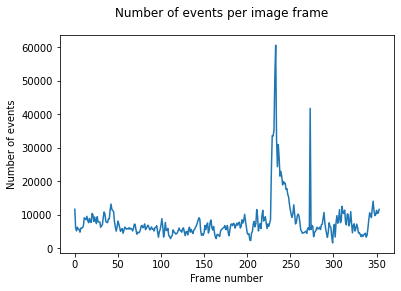

In [13]:
n_events_per_image = []

prev_timestamp = -1
for i in range(1, len(images_df)):
    image_timestamp = images_df.iloc[i].secs
    n_events = len(
        events_df[
            (prev_timestamp <= events_df.secs) & (events_df.secs <= image_timestamp)
        ]
    )
    n_events_per_image.append(n_events)
    prev_timestamp = image_timestamp

plt.suptitle("Number of events per image frame")
plt.xlabel("Frame number")
plt.ylabel("Number of events")
plt.plot(n_events_per_image);


### Check image frames frequency


Average milliseconds: 25.3531, Average fps: 39.44


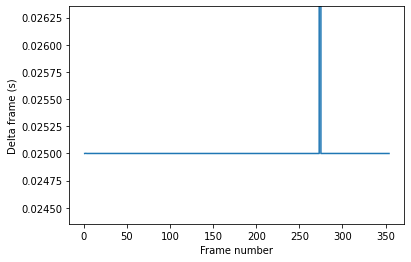

In [14]:
deltas = images_df.secs.diff()
mean_secs = np.mean(deltas)
plt.ylim(mean_secs - 0.001, mean_secs + 0.001)
plt.ylabel("Delta frame (s)")
plt.xlabel("Frame number")
plt.plot(deltas[1:])
print(
    "Average milliseconds: {:.4f}, Average fps: {:.2f}".format(
        mean_secs * 1000, 1 / mean_secs
    )
)


### Save events for visualization


In [ ]:
def get_empty_images(
    w: int, h: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Return four grey empty images of size `w` x `h`, one for each Bayer channel (RGGB).
    """
    red_img = np.ones(shape=(h, w, 3), dtype=np.uint8) * 127
    green1_img = red_img.copy()
    green2_img = red_img.copy()
    blue_img = red_img.copy()
    return red_img, green1_img, green2_img, blue_img


def save_visual_events(
    events_df: pd.DataFrame, w: int, h: int, output_dir, batch_n_events=10000
):
    """
    Save visual events by batching them.
    The output is going to have four sectors, one for each RGGB filter.
    """
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    reconstructed_image = np.zeros(shape=(h, w), dtype=np.uint8)
    red_img, green1_img, green2_img, blue_img = get_empty_images(w, h)

    if not os.path.exists(os.path.join(output_dir, "visual_events")):
        os.mkdir(os.path.join(output_dir, "visual_events"))
    if not os.path.exists(os.path.join(output_dir, "visual_images")):
        os.mkdir(os.path.join(output_dir, "visual_images"))

    for i, (index, event) in enumerate(
        tqdm(events_df.iterrows(), total=len(events_df))
    ):
        cur_timestamp = int(event.secs)
        mod = (event.x % 2, event.y % 2)

        reconstructed_image[event.y][event.x] += event.polarity * 20

        if mod == (0, 0):
            red_img[event.y][event.x] = [255, 0, 0] if event.polarity else [0, 0, 0]
        elif mod == (1, 0):
            green1_img[event.y][event.x] = [0, 255, 0] if event.polarity else [0, 0, 0]
        elif mod == (0, 1):
            green2_img[event.y][event.x] = [0, 255, 0] if event.polarity else [0, 0, 0]
        elif mod == (1, 1):
            blue_img[event.y][event.x] = [0, 0, 255] if event.polarity else [0, 0, 0]

        if i % batch_n_events == 0:
            final_img = np.vstack(
                (np.hstack((red_img, green1_img)), np.hstack((green2_img, blue_img)))
            )
            plt.suptitle(cur_timestamp)
            plt.imsave(os.path.join(output_dir, f"visual_events/{i}.png"), final_img)
            plt.imsave(
                os.path.join(output_dir, f"visual_images/{i}.png"),
                reconstructed_image.astype(np.uint8),
                vmin=0,
                vmax=255,
            )
            reconstructed_image = np.zeros(shape=(h, w), dtype=np.uint8)
            red_img, green1_img, green2_img, blue_img = get_empty_images(w, h)


w, h = images_df.iloc[0].width, images_df.iloc[0].height
folder_name = os.path.basename(dataset_path).replace(".bag", "")
output_dir = os.path.join(os.path.dirname(dataset_path), folder_name)
save_visual_events(events_df, w, h, output_dir)


## Dataset Preparation


In [9]:
class Event:
    def __init__(self, x: int, y: int, timestamp: float, polarity: int):
        self.x = x
        self.y = y
        self.timestamp = timestamp
        self.polarity = polarity


def create_event_grid(
    events: List[Event], w: int, h: int, n_temp_bins: int
) -> np.array:
    """
    Create an event grid with shape `(n_temp_bins, h, w)`.
    Each event polarity is assigned proportionally to the two closest temporal bins.
    Events should be sorted by timestamp.
    """
    event_grid = np.zeros(shape=(n_temp_bins, h, w))
    smallest_timestamp = events[0].timestamp
    highest_timestamp = events[-1].timestamp

    for event in events:
        temp_bin = (
            (event.timestamp - smallest_timestamp)
            / (highest_timestamp - smallest_timestamp + 1e-6)
        ) * (n_temp_bins - 1)

        int_bin = int(temp_bin)
        decimal_part = temp_bin - int_bin

        event_grid[int_bin, event.y, event.x] += event.polarity * (1 - decimal_part)
        if decimal_part != 0:
            event_grid[int_bin + 1, event.y, event.x] += event.polarity * decimal_part
    return event_grid


def dataset_generator(bag_path: str, image_type: str, n_temp_bins=10):
    if image_type not in ["color", "raw"]:
        raise Exception(
            "image_type must be either 'color' or 'raw'. "
            + image_type
            + " is not a valid option."
        )

    # Preload image frames to get timestamps
    images = []
    w, h = 0, 0
    with rosbag.Bag(bag_path) as bag:
        for topic, msg, _ in bag.read_messages(topics=["/dvs/image_" + image_type]):
            w, h = msg.width, msg.height
            channels = 3 if image_type == "color" else 1
            image = bgr_to_rgb(image_from_buffer(msg.data, w, h, channels))
            images.append((msg.header.stamp.to_sec(), image))
    print("Images loaded")

    current_img_idx = 1
    events_batch: List[Event] = []

    with rosbag.Bag(bag_path) as bag:
        msg_count = bag.get_message_count("/dvs/events")

        # Group events before image frame
        for _, msg, _ in tqdm(bag.read_messages("/dvs/events"), total=msg_count):
            for event in msg.events:
                cur_image_ts = images[current_img_idx][0]
                event_obj = Event(event.x, event.y, event.ts.to_sec(), event.polarity)

                if event_obj.timestamp <= cur_image_ts:
                    events_batch.append(event_obj)
                else:
                    current_img_idx += 1
                    event_grid = create_event_grid(
                        events_batch, w, h, n_temp_bins=n_temp_bins
                    )
                    events_batch = []
                    yield (
                        (images[current_img_idx - 2][1], event_grid),
                        images[current_img_idx - 1][1],
                    )
                    if current_img_idx == len(images):
                        return


def save_batches_to_disk(ds, dst_folder: str = None):
    if not os.path.exists(dst_folder):
        os.mkdir(dst_folder)
    for i, batch in enumerate(ds):
        torch.save(batch, os.path.join(dst_folder, "batch_{:04}.pt".format(i)))


In [10]:
ds_gen = dataset_generator(dataset_path, "color")
dst_folder = os.path.join(
    os.path.dirname(dataset_path),
    os.path.basename(dataset_path).replace(".bag", ""),
    "batches",
)
save_batches_to_disk(ds_gen, dst_folder)


NameError: name 'bgr_to_rgb' is not defined

In [ ]:
def load_batches_from_disk(path: str):
    for batch_file in os.listdir(path):
        if batch_file.endswith(".pt"):
            yield torch.load(os.path.join(path, batch_file))


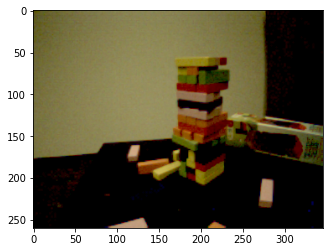

(10, 260, 346)


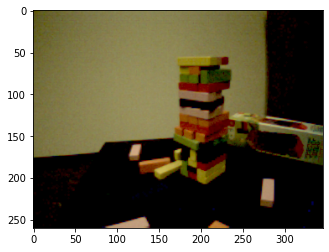

In [ ]:
batches_path = r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple\simple_jenga_destroy\batches"
for batch in load_batches_from_disk(batches_path):
    (in_, events), out_ = batch
    plot_img(in_)
    print(events.shape)
    plot_img(out_)
    break


## PyTorch Dataset and DataLoader


In [16]:
class CEDDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str, single_dataset: str = None):
        self.dataset_path = dataset_path
        self.single_dataset = single_dataset
        self.files_list = []

        directories = []
        if single_dataset:
            directories = [os.path.join(dataset_path, single_dataset)]
        else:
            for file in os.listdir(dataset_path):
                file_path = os.path.join(dataset_path, file)
                if os.path.isdir(file_path):
                    directories.append(file_path)

        for directory in directories:
            for file in os.listdir(directory):
                if file.endswith(".pt"):
                     self.files_list.append(os.path.join(directory, file))

        self.files_list = sorted(self.files_list)

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx: int):
        file = self.files_list[idx]
        (in_img, events), out_img = torch.load(file)
        in_img = (in_img[:256, :336, :] / 255.0).astype(np.float32)
        out_img = (out_img[:256, :336, :] / 255.0).astype(np.float32)

        return (in_img, events[:, :256, :336].astype(np.float32)), out_img


In [17]:
dataset_path = (
    r"E:\Cartelle Personali\Fabrizio\Universita\Magistrale\Tesi\03 - Dataset\CED_simple"
)
ds = CEDDataset(dataset_path, "simple_color_keyboard_2")
train_dataloader = torch.utils.data.DataLoader(ds, batch_size=1)


# UNet AutoEncoder Model


## Model Definition


In [11]:
class EventsToImages(torch.nn.Module):
    def __init__(self, input_channels):
        super(EventsToImages, self).__init__()
        self.input_channels = input_channels

        self.conv64 = self.double_conv_block(self.input_channels, 64, 3)
        self.conv128 = self.double_conv_block(64, 128, 3)
        self.conv256 = self.double_conv_block(128, 256, 3)
        self.conv512 = self.double_conv_block(256, 512, 3)
        self.conv1024 = self.conv_block(512, 1024, 3)

        self.conv512_ = self.double_conv_block(512 + 1024, 512, 3)
        self.conv256_ = self.double_conv_block(256 + 512, 256, 3)
        self.conv128_ = self.double_conv_block(128 + 256, 128, 3)
        self.conv64_ = self.double_conv_block(64 + 128, 64, 3)

        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = torch.nn.Upsample(scale_factor=2)
        self.final_block = torch.nn.Sequential(
            torch.nn.Conv2d(64, 3, 1), torch.nn.BatchNorm2d(3), torch.nn.Sigmoid()
        )

    def forward(self, x):
        first_block = self.conv64(x)
        x = self.max_pool(first_block)

        second_block = self.conv128(x)
        x = self.max_pool(second_block)

        third_block = self.conv256(x)
        x = self.max_pool(third_block)

        last_block = self.conv512(x)
        x = self.max_pool(last_block)

        x = self.conv1024(x)

        x = self.upsample(x)
        x = torch.cat((last_block, x), dim=1)
        x = self.conv512_(x)

        x = self.upsample(x)
        x = torch.cat((third_block, x), dim=1)
        x = self.conv256_(x)

        x = self.upsample(x)
        x = torch.cat((second_block, x), dim=1)
        x = self.conv128_(x)

        x = self.upsample(x)
        x = torch.cat((first_block, x), dim=1)
        x = self.conv64_(x)

        x = self.final_block(x)

        return x

    def double_conv_block(self, in_channels, out_channels, size):
        return torch.nn.Sequential(
            self.conv_block(in_channels, out_channels, size),
            self.conv_block(out_channels, out_channels, size),
        )

    def conv_block(self, in_channels, out_channels, size):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, size, padding="same"),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )


In [12]:
from torchsummary import summary

input_channels = 3 + 10
model = EventsToImages(input_channels)
summary(model, input_size=(13, 260, 346))


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  7,552
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
├─Sequential: 1-2                        --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-7                  73,856
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-10                 147,584
|    |    └─BatchNorm2d: 3-11            256
|    |    └─ReLU: 3-12                   --
├─Sequential: 1-3                        --
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-13                 295,168
| 

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  7,552
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    └─Sequential: 2-2                   --
|    |    └─Conv2d: 3-4                  36,928
|    |    └─BatchNorm2d: 3-5             128
|    |    └─ReLU: 3-6                    --
├─Sequential: 1-2                        --
|    └─Sequential: 2-3                   --
|    |    └─Conv2d: 3-7                  73,856
|    |    └─BatchNorm2d: 3-8             256
|    |    └─ReLU: 3-9                    --
|    └─Sequential: 2-4                   --
|    |    └─Conv2d: 3-10                 147,584
|    |    └─BatchNorm2d: 3-11            256
|    |    └─ReLU: 3-12                   --
├─Sequential: 1-3                        --
|    └─Sequential: 2-5                   --
|    |    └─Conv2d: 3-13                 295,168
| 

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


## Model Training


In [20]:
model = EventsToImages(input_channels).to(device)

n_epochs = 10
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(n_epochs):
    start_epoch_time = time.time()
    batch_losses = []
    print(
        "Epoch {} Step {}/{} Loss: {:.3f}".format(0, 0, len(train_dataloader), 0),
        end="",
    )
    for step, batch in enumerate(train_dataloader):
        (input_images, events_tensors), ground_truth_images = batch
        input_images = torch.einsum("bhwc -> bchw", input_images)

        input_tensors = torch.hstack((input_images, events_tensors))
        input_tensors = input_tensors.to(device)

        generated_images = model(input_tensors)

        ground_truth_images = torch.einsum("bhwc -> bchw", ground_truth_images).to(
            device
        )
        loss: torch.Tensor = criterion(generated_images, ground_truth_images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_losses.append(loss.cpu().detach())

        print(
            "\rEpoch {} Step {}/{} Loss: {:.3f}".format(
                epoch, step, len(train_dataloader), loss
            ),
            end="",
        )
    elapsed_time = time.time() - start_epoch_time
    print(
        "Epoch {} Step {}/{} Mean Loss: {:.3f} Elapsed Seconds: {}s".format(
            0, 0, len(train_dataloader), np.mean(batch_losses), int(elapsed_time)
        )
    )


Epoch 0 Step 158/159 Loss: 0.103Epoch 0 Step 0/159 Mean Loss: 0.108 Elapsed Seconds: 30s
Epoch 1 Step 158/159 Loss: 0.082Epoch 0 Step 0/159 Mean Loss: 0.085 Elapsed Seconds: 30s
Epoch 2 Step 158/159 Loss: 0.066Epoch 0 Step 0/159 Mean Loss: 0.067 Elapsed Seconds: 30s
Epoch 3 Step 158/159 Loss: 0.054Epoch 0 Step 0/159 Mean Loss: 0.054 Elapsed Seconds: 30s
Epoch 4 Step 158/159 Loss: 0.045Epoch 0 Step 0/159 Mean Loss: 0.044 Elapsed Seconds: 30s
Epoch 5 Step 154/159 Loss: 0.038

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model_thesis.pt")


In [24]:
# Save input frames as video
imgs = []
for batch in tqdm(train_dataloader):
    (input_images, events_tensors), ground_truth_images = batch
    imgs += input_images
save_video_tensors("input_video.mp4", imgs, 336, 256, 30)


100%|██████████| 159/159 [00:03<00:00, 46.77it/s]


In [27]:
# Save generated frames as video
use_prev_images_as_input = False

imgs = []
for i, batch in enumerate(tqdm(train_dataloader)):
    if use_prev_images_as_input and i != 0:
        input_images = generated_images
    else:
        (input_images, events_tensors), ground_truth_images = batch
    input_images = torch.einsum("bhwc -> bchw", input_images)

    input_tensors = torch.hstack((input_images, events_tensors))
    input_tensors = input_tensors.to(device)

    generated_images = model(input_tensors).cpu().detach()
    generated_images = torch.einsum("bchw -> bhwc", generated_images)

    imgs += generated_images

save_video_tensors("generated_video.mp4", imgs, 336, 256, 30)


100%|██████████| 159/159 [00:13<00:00, 12.14it/s]


In [ ]:
# BS = 1; Seconds for one epoch: 142.36227083206177
# BS = 2; Seconds for one epoch: 132.93124723434448
# BS = 4; Seconds for one epoch: 127.95218682289124
# BS = 8; Seconds for one epoch: 138.49955368041992
# BS = 16; Seconds for one epoch: after 180 seconds it was at 3/10 batches so I stopped it


# Transformer Model


## Model definition


In [19]:
class TransformerModel(torch.nn.Module):
    def __init__(self, encoding_size: int, heads: int, layers_number: int):
        super(TransformerModel, self).__init__()
        self.transformer = torch.nn.Transformer(
            d_model=encoding_size,
            nhead=heads,
            num_encoder_layers=layers_number,
            num_decoder_layers=layers_number,
        )

    def forward(self, x):
        self.transfomer()
